In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [5]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import scenario_generator.curated as curated
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, query_starboard_sector_expirations
from mechafil.power import forecast_power_stats, build_full_power_stats_df

In [104]:
SIM_START_LAG_DAYS = 10
current_date = datetime.datetime.now().date() - datetime.timedelta(days=SIM_START_LAG_DAYS)
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

forecast_lenght = 365*2
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

duration = 360

scenario_params = curated.forecast_pessimistic_scenario(forecast_lenght)
rb_onboard_power_vec = scenario_params['rb_onboard_power']
renewal_rate_vec = scenario_params['renewal_rate']
filplus_rate_vec = scenario_params['filplus_rate']

res = get_sector_expiration_stats(start_date, current_date,end_date)
rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]
scheduled_df = query_starboard_sector_expirations(start_date, end_date)
filter_scheduled_df = scheduled_df[
    scheduled_df["date"] >= pd.to_datetime(current_date, utc="UTC")
]
rb_known_scheduled_expire_tvec = filter_scheduled_df["date"]
# fsd2 = filter_scheduled_df[filter_scheduled_df['date'] <= max_date]
fsd2 = filter_scheduled_df[filter_scheduled_df['date'].dt.date <= (current_date + datetime.timedelta(days=duration))]
rb_known_scheduled_expire_vec2 = fsd2['total_rb'].values
qa_known_scheduled_expire_vec2 = fsd2['total_qa'].values
    
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
    
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_vec,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec,
        filplus_rate_vec,
        duration,
        forecast_lenght,
        qap_method='basic'
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
    
power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
)
print(np.min(power_df.total_raw_power_eib))

-1.7814984890818386


In [105]:
scheduled_df.columns

Index(['stat_date', 'observe_height', 'interest_date', 'start_date_epoch',
       'end_date_epoch', 'schedule_expire_bytes', 'extended_bytes',
       'terminated_bytes', 'expired_bytes', 'potential_expire_bytes',
       'schedule_expire_pledge', 'extended_pledge', 'terminated_pledge',
       'expired_pledge', 'potential_expire_pledge',
       'schedule_expire_bytes_qap', 'extended_bytes_qap',
       'terminated_bytes_qap', 'expired_bytes_qap',
       'potential_expire_bytes_qap', 'extended_rb', 'expired_rb', 'open_rb',
       'extended_qa', 'expired_qa', 'open_qa', 'total_rb', 'total_qa',
       'total_pledge', 'schedule_expire_rb', 'schedule_expire_qa', 'date'],
      dtype='object')

<IPython.core.display.Javascript object>


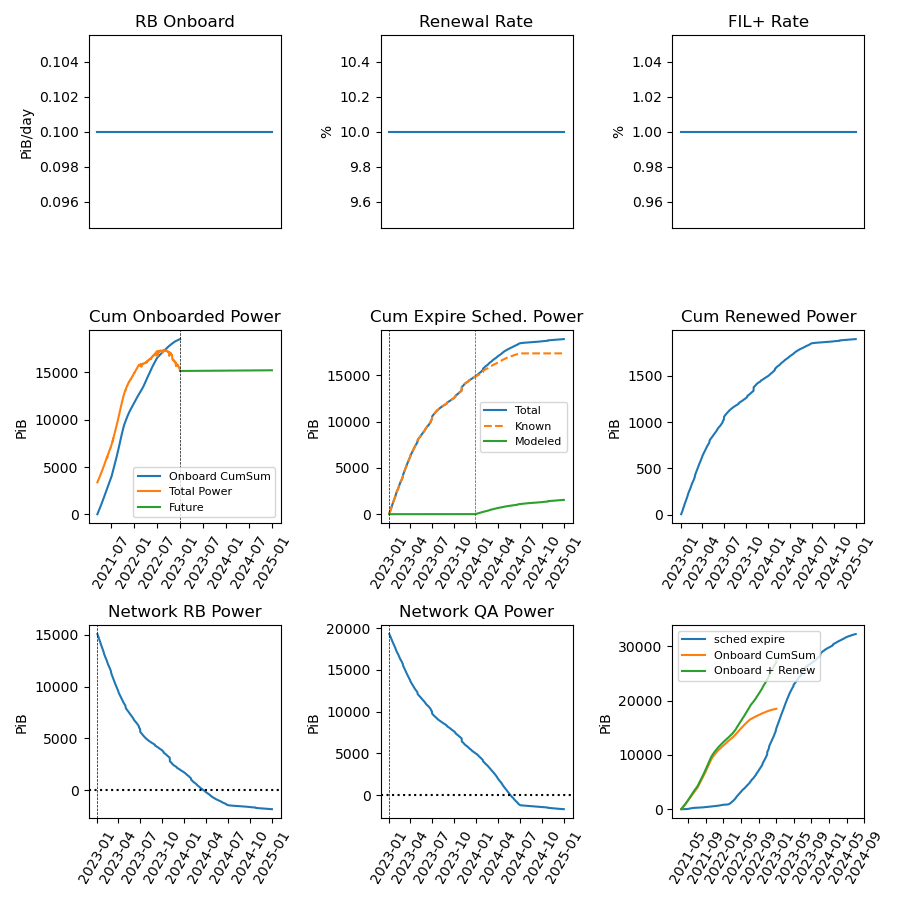

In [106]:
PIB = 2**50
plt.figure(figsize=(9,9))

t_forecast_start = current_date + datetime.timedelta(days=1)
t_forecast = np.asarray([t_forecast_start + datetime.timedelta(days=x) for x in range(forecast_lenght)])

plt.subplot(3,3,1)
plt.plot(t_forecast, rb_onboard_power_vec)
plt.title('RB Onboard')
plt.xticks([])
plt.ylabel('PiB/day')

plt.subplot(3,3,2)
plt.plot(t_forecast, renewal_rate_vec*100)
plt.title('Renewal Rate')
plt.xticks([])
plt.ylabel('%')

plt.subplot(3,3,3)
plt.plot(t_forecast, filplus_rate_vec*10)
plt.title('FIL+ Rate')
plt.xticks([])
plt.ylabel('%')

plt.subplot(3,3,4)
plt.plot(fil_stats_df['date'], fil_stats_df['day_onboarded_rb_power_pib'].cumsum(), label='Onboard CumSum')
plt.plot(fil_stats_df['date'], fil_stats_df['total_raw_power_eib']*1024, label='Total Power')
plt.plot(t_forecast, rb_power_df['cum_onboarded_power'] + np.ones(forecast_lenght)*rb_power_zero, label='Future')
plt.xticks(rotation=60)
plt.title('Cum Onboarded Power')
plt.axvline(current_date, linestyle='--', color='k', linewidth=0.5)
plt.ylabel('PiB')
plt.legend(fontsize=8)

plt.subplot(3,3,5)
# plt.plot(scheduled_df['date'], (scheduled_df['schedule_expire_bytes'].astype(float)-scheduled_df['terminated_bytes'].astype(float)).cumsum()/PIB)
plt.plot(t_forecast, rb_power_df['cum_expire_scheduled_power'], label='Total')
plt.plot(t_forecast, rb_power_df['expire_scheduled_known_power'].cumsum(), label='Known', linestyle='--')
plt.plot(t_forecast, rb_power_df['expire_scheduled_modeled_power'].cumsum(), label='Modeled')
plt.axvline(current_date, linestyle='--', color='k', linewidth=0.5)
plt.axvline(current_date + datetime.timedelta(days=duration), linestyle='--', color='r', linewidth=0.5)
# plt.axvline(rb_known_scheduled_expire_tvec.iloc[0], linestyle='--')
# plt.plot(rb_known_scheduled_expire_tvec, rb_known_scheduled_expire_vec, label='Known')
plt.xticks(rotation=60)
plt.title('Cum Expire Sched. Power')
plt.ylabel('PiB')
plt.legend(fontsize=8)

plt.subplot(3,3,6)
plt.plot(t_forecast, rb_power_df['cum_renewed_power'])
plt.xticks(rotation=60)
plt.title('Cum Renewed Power')
plt.ylabel('PiB')

plt.subplot(3,3,7)
plt.plot(t_forecast, rb_power_df['total_power'])
plt.axhline(0, linestyle=':', color='k')
plt.axvline(current_date, linestyle='--', color='k', linewidth=0.5)
plt.xticks(rotation=60)
plt.title('Network RB Power')
plt.ylabel('PiB')

plt.subplot(3,3,8)
plt.plot(t_forecast, qa_power_df['total_power'])
plt.axhline(0, linestyle=':', color='k')
plt.axvline(current_date, linestyle='--', color='k', linewidth=0.5)
plt.xticks(rotation=60)
plt.title('Network QA Power')
plt.ylabel('PiB')

plt.subplot(3,3,9)
sched_df_subset = scheduled_df[(scheduled_df['date'].dt.date<=fil_stats_df['date'].iloc[-1]) & (scheduled_df['date'].dt.date>=fil_stats_df['date'].iloc[0])]
plt.plot(scheduled_df['date'], 
         (scheduled_df['schedule_expire_bytes'].astype(float)-scheduled_df['terminated_bytes'].astype(float)).cumsum()/PIB,
        label='sched expire')
plt.plot(fil_stats_df['date'], fil_stats_df['day_onboarded_rb_power_pib'].cumsum(), label='Onboard CumSum')
plt.plot(sched_df_subset['date'], (fil_stats_df['day_onboarded_rb_power_pib'].values + sched_df_subset['extended_rb'].values).cumsum(), label='Onboard + Renew')
plt.legend(fontsize=8)
plt.xticks(rotation=60)
plt.ylabel('PiB')

plt.tight_layout()

<IPython.core.display.Javascript object>


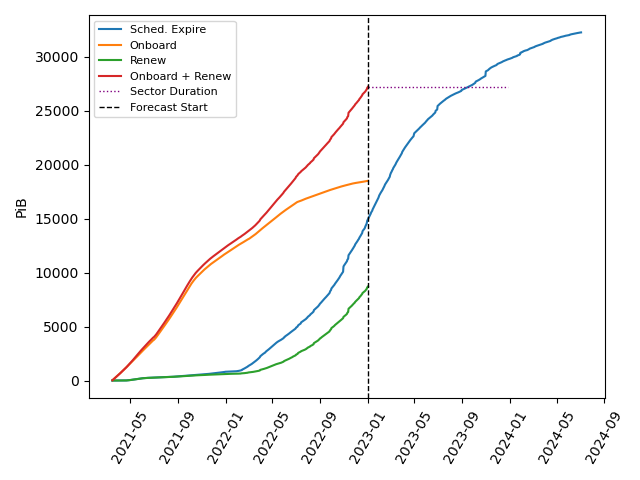

In [103]:
plt.figure()
sched_df_subset = scheduled_df[(scheduled_df['date'].dt.date<=fil_stats_df['date'].iloc[-1]) & (scheduled_df['date'].dt.date>=fil_stats_df['date'].iloc[0])]
y_expire = (scheduled_df['schedule_expire_bytes'].astype(float)-scheduled_df['terminated_bytes'].astype(float)).cumsum()/PIB
plt.plot(scheduled_df['date'], y_expire, label='Sched. Expire')
plt.plot(fil_stats_df['date'], fil_stats_df['day_onboarded_rb_power_pib'].cumsum(), label='Onboard')
plt.plot(sched_df_subset['date'], sched_df_subset['extended_rb'].cumsum(), label='Renew')
y_total = (fil_stats_df['day_onboarded_rb_power_pib'].values + sched_df_subset['extended_rb'].values).cumsum()
plt.plot(sched_df_subset['date'], y_total, label='Onboard + Renew')
x1 = sched_df_subset['date'].iloc[-1]
x2 = x1 + datetime.timedelta(days=duration)
y1 = y_total[-1]; y2 = y1
plt.plot([x1, x2], [y1, y2], color='purple', linestyle=':', linewidth=1, label='Sector Duration')
plt.axvline(current_date, color='k', linestyle='--', label='Forecast Start', linewidth=1)
plt.legend(fontsize=8)
plt.xticks(rotation=60)
plt.ylabel('PiB')
plt.tight_layout()

y_total_max = y_total[-1]


In [91]:
ii = np.abs(y_expire-y_total_max).argmin()
max_date = scheduled_df['date'].iloc[ii]
print(max_date)

2023-09-15 00:00:00+00:00


In [35]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
expirations_df = query_starboard_sector_expirations(start_date,end_date)

In [37]:
expirations_df['date'] = expirations_df['date'].dt.date
full_df = fil_stats_df.merge(expirations_df, on='date', how='inner')

In [38]:
plt.figure()
plt.plot(full_df['date'], full_df['total_raw_power_eib']*1024, label='total')

onboard_cumsum = full_df['day_onboarded_rb_power_pib'].cumsum()
expired_cumsum = full_df['schedule_expire_rb'].cumsum()


,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,...,expired_rb,open_rb,extended_qa,expired_qa,open_qa,total_rb,total_qa,total_pledge,schedule_expire_rb,schedule_expire_qa
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,30.751831,30.778159,...,0.000305,0.000000,0.000000,0.000305,0.000000,0.000305,0.000305,1.000000e+01,0.000854,0.000854
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,31.845703,31.854920,...,0.000061,0.000000,0.000000,0.000061,0.000000,0.000061,0.000061,1.200215e+00,0.000153,0.000153
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.429504,31.464130,...,0.000031,0.000000,0.000000,0.000031,0.000000,0.000031,0.000031,3.629450e-01,0.000061,0.000061
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.384003,31.454148,...,0.000031,0.000000,0.000000,0.000031,0.000000,0.000031,0.000031,3.595657e-01,0.000244,0.000244
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.441833,32.462359,...,0.000092,0.000000,0.000000,0.000092,0.000000,0.000092,0.000092,1.589116e+00,0.000275,0.000275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,4.133480e+08,2.492597e+08,3.170409e+08,1.359921e+08,3.402713e+07,2022-12-28,15.043900,19.055781,7.030731,27.435375,...,26.016266,0.076447,61.335181,26.302877,0.076447,87.406433,87.714504,5.669172e+05,89.219940,89.547000
653,4.138531e+08,2.495246e+08,3.173089e+08,1.360164e+08,3.403059e+07,2022-12-29,14.996147,19.041435,6.225769,32.253103,...,28.650421,-0.315826,32.262543,28.852651,-0.315826,60.586578,60.799368,3.990808e+05,61.979614,62.203856
654,4.145815e+08,2.497859e+08,3.175769e+08,1.357172e+08,3.413066e+07,2022-12-30,14.900151,18.963998,5.587097,33.051052,...,74.408203,-0.094391,36.803076,74.835460,-0.094391,111.102020,111.544145,6.962923e+05,112.731049,113.176188
655,4.154076e+08,2.500474e+08,3.178448e+08,1.353999e+08,3.415135e+07,2022-12-31,14.838597,18.924242,6.306488,32.150746,...,78.584198,-0.178650,124.082786,79.280368,-0.178650,202.457764,203.184504,1.423895e+06,204.182159,204.908900


In [39]:
full_df.columns

Index(['circulating_fil', 'mined_fil', 'vested_fil', 'locked_fil', 'burnt_fil',
       'date', 'total_raw_power_eib', 'total_qa_power_eib',
       'day_onboarded_rb_power_pib', 'day_onboarded_qa_power_pib',
       'rb_renewal_rate', 'day_renewed_qa_power_pib', 'stat_date',
       'observe_height', 'interest_date', 'start_date_epoch', 'end_date_epoch',
       'schedule_expire_bytes', 'extended_bytes', 'terminated_bytes',
       'expired_bytes', 'potential_expire_bytes', 'schedule_expire_pledge',
       'extended_pledge', 'terminated_pledge', 'expired_pledge',
       'potential_expire_pledge', 'schedule_expire_bytes_qap',
       'extended_bytes_qap', 'terminated_bytes_qap', 'expired_bytes_qap',
       'potential_expire_bytes_qap', 'extended_rb', 'expired_rb', 'open_rb',
       'extended_qa', 'expired_qa', 'open_qa', 'total_rb', 'total_qa',
       'total_pledge', 'schedule_expire_rb', 'schedule_expire_qa'],
      dtype='object')